In [1]:
# Кравцов Андрей ИУ5-64Б Вариант 10
#Загрузка датасета
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import Image
from IPython.core.display import HTML

In [2]:
wine = pd.read_csv('winequality-red.csv',encoding='latin-1')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


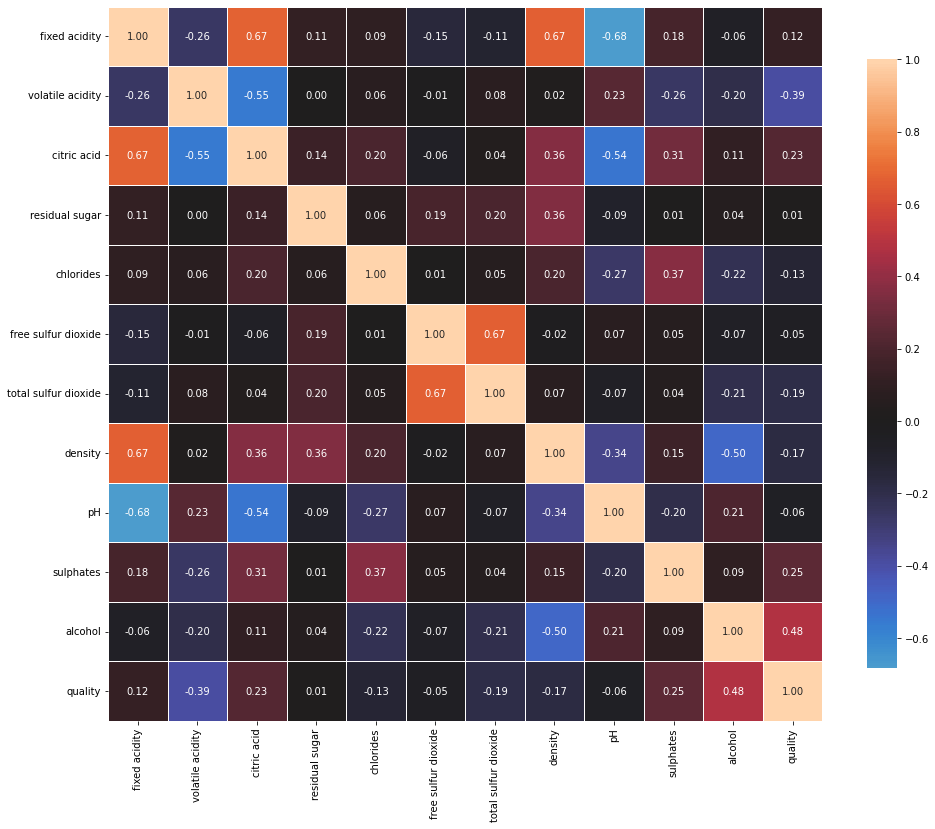

In [4]:
#Коррелляционный анализ
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(16,16))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.70})
    plt.show()
correlation_heatmap(wine)

In [5]:
print('Признаки, имеющие максимальную по модулю корреляцию с качеством вина')
best_params = wine.corr()['quality'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.1]
best_params

Признаки, имеющие максимальную по модулю корреляцию с качеством вина


alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
Name: quality, dtype: float64

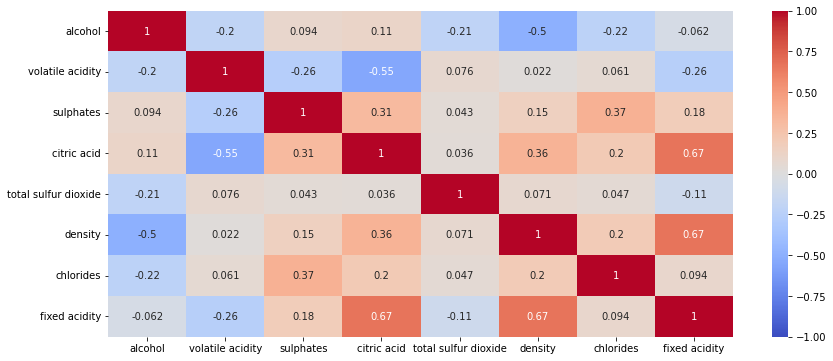

In [6]:
plt.figure(figsize=(14, 6))
sns.heatmap(wine[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

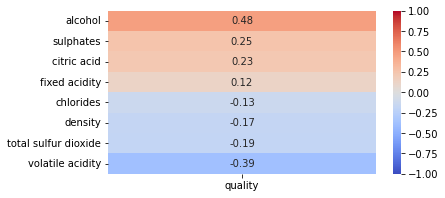

In [7]:
plt.figure(figsize=(6, 3))
sns.heatmap(pd.DataFrame(wine[np.append(best_params.index.values, 'quality')].corr()['quality'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

In [10]:
#Разделение выборки на обучающую и тестовую
y = wine['quality']
X = wine[best_params.index]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
# Линейная регрессия
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred_linear = linear_model.predict(x_test)
print_metrics(y_test, y_pred_linear)

R^2: 0.38238497322926734
MSE: 0.39595717543112724
MAE: 0.48817437246113815


In [11]:
# Полиномиальная регрессия
poly_model = PolynomialFeatures(degree=3)
x_train_poly = poly_model.fit_transform(x_train)
x_test_poly = poly_model.fit_transform(x_test)
linear_model = LinearRegression()
linear_model.fit(x_train_poly, y_train)
y_pred_poly = linear_model.predict(x_test_poly)
print_metrics(y_test, y_pred_poly)

R^2: -0.5708380860399436
MSE: 1.0070749328430824
MAE: 0.5754265019107455


In [12]:
# SVM
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train_scaled.describe()

,alcohol,volatile acidity,sulphates,citric acid,total sulfur dioxide,density,chlorides,fixed acidity
count,1.119000e+03,1.119000e+03,1.119000e+03,1.119000e+03,1.119000e+03,1.119000e+03,1.119000e+03,1.119000e+03
mean,1.416006e-15,-5.667197e-16,-1.015968e-16,4.444861e-17,-1.269960e-17,-2.365936e-14,8.889721e-17,-3.936877e-16
std,1.000447e+00,1.000447e+00,1.000447e+00,1.000447e+00,1.000447e+00,1.000447e+00,1.000447e+00,1.000447e+00
min,-1.917741e+00,-2.254571e+00,-1.724135e+00,-1.409539e+00,-1.251276e+00,-3.577004e+00,-1.669894e+00,-2.148858e+00
25%,-8.761087e-01,-7.472164e-01,-6.448023e-01,-8.950986e-01,-7.849751e-01,-6.210177e-01,-3.687419e-01,-7.147652e-01
50%,-2.132516e-01,-2.145310e-02,-2.250619e-01,-7.199406e-02,-2.565004e-01,-6.300747e-03,-1.668390e-01,-2.558555e-01
75%,6.389932e-01,5.926543e-01,4.345302e-01,7.511105e-01,4.584948e-01,5.816894e-01,7.993118e-02,5.472365e-01
max,4.237360e+00,5.896309e+00,8.049820e+00,3.734864e+00,3.691517e+00,3.703382e+00,1.176787e+01,4.333242e+00


In [13]:
# Дерево решений
params = {'C': np.concatenate([np.arange(0.1, 2, 0.1), np.arange(2, 15, 1)])}
svm_model = SVR(kernel='linear')
grid_cv = GridSearchCV(estimator=svm_model, param_grid=params, cv=10, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train_scaled, y_train)
print(grid_cv.best_params_)

{'C': 0.1}


In [14]:
best_svm_model = grid_cv.best_estimator_
best_svm_model = SVR(kernel='linear', C=11)
best_svm_model.fit(x_train_scaled, y_train)
y_pred_svm = best_svm_model.predict(x_test_scaled)
print_metrics(y_test, y_pred_svm)

R^2: 0.363389939423866
MSE: 0.40813502021597803
MAE: 0.4874839719251867


In [15]:
params = {'min_samples_leaf': range(3, 30)}
tree = DecisionTreeRegressor(random_state=3)
grid_cv = GridSearchCV(estimator=tree, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 22}


In [16]:
best_tree = grid_cv.best_estimator_
best_tree.fit(x_train, y_train)
y_pred_tree = best_tree.predict(x_test)
print_metrics(y_test, y_pred_tree)

R^2: 0.3648680876169246
MSE: 0.4071873694011131
MAE: 0.4888854551410971


In [17]:
importances = pd.DataFrame(data=zip(x_train.columns, best_tree.feature_importances_), columns=['Признак', 'Важность'])
print('Важность признаков в дереве решений\n')
for row in importances.sort_values(by='Важность', ascending=False).values:
    print(f'{row[0]}: {round(row[1], 3)}')

Важность признаков в дереве решений

alcohol: 0.48
sulphates: 0.234
volatile acidity: 0.106
total sulfur dioxide: 0.075
chlorides: 0.051
citric acid: 0.042
density: 0.013
fixed acidity: 0.0


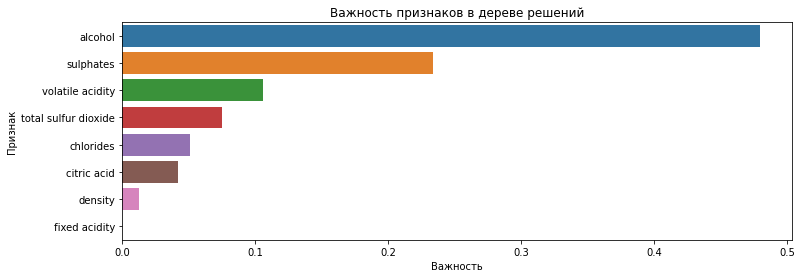

In [18]:
plt.figure(figsize=(12, 4))
sns.barplot(data=importances.sort_values(by='Важность', ascending=False), y='Признак', x='Важность', orient='h', )
plt.title('Важность признаков в дереве решений')
plt.show()

In [19]:
#Сравнение моделей
print('Линейная регрессия')
print_metrics(y_test, y_pred_linear)

print('\nПолиномиальная регрессия')
print_metrics(y_test, y_pred_poly)

print('\nМетод опорных векторов')
print_metrics(y_test, y_pred_svm)

print('\nДерево решений')
print_metrics(y_test, y_pred_tree)

Линейная регрессия
R^2: 0.38238497322926734
MSE: 0.39595717543112724
MAE: 0.48817437246113815

Полиномиальная регрессия
R^2: -0.5708380860399436
MSE: 1.0070749328430824
MAE: 0.5754265019107455

Метод опорных векторов
R^2: 0.363389939423866
MSE: 0.40813502021597803
MAE: 0.4874839719251867

Дерево решений
R^2: 0.3648680876169246
MSE: 0.4071873694011131
MAE: 0.4888854551410971
